In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import csv
import datetime
from dateutil.parser import parse
from pandas.tools.plotting import scatter_matrix
from patsy import dmatrices
import statsmodels.formula.api as smf

%matplotlib inline

In [60]:
complete_df = pd.read_csv("complete_post2010.csv")

In [78]:
complete_df = complete_df[np.isfinite(complete_df['comments_score'])]
complete_df = complete_df[np.isfinite(complete_df['posts_score'])]
complete_df = complete_df[np.isfinite(complete_df['foreign_gross'])]
complete_df = complete_df[np.isfinite(complete_df['opening_weekend'])]

complete_df["opening_weekend"] = complete_df["opening_weekend"].apply(lambda x: int(x))
complete_df["foreign_gross"] = complete_df["foreign_gross"].apply(lambda x: int(x))
# complete_df["release_date"] = complete_df["release_date"].apply(lambda x: parse(x).date())

complete_df = complete_df[complete_df['comments_score']>0]
complete_df = complete_df[complete_df['posts_score']>0]

complete_df["reddit_buzz"]=complete_df['comments_score']+complete_df["posts_score"]
complete_df = complete_df[complete_df['reddit_buzz']>0]
complete_df["opening_weekend_adj"] = complete_df['opening_weekend']*3

In [79]:
complete_df.describe()

,opening_weekend,foreign_gross,posts_score,comments_score,reddit_buzz,opening_weekend_adj
count,5.740000e+02,5.740000e+02,574.000000,574.000000,574.000000,5.740000e+02
mean,2.250218e+07,1.103344e+08,5178.818815,31792.092334,36970.911150,6.750653e+07
std,2.728470e+07,1.585056e+08,6640.978680,49707.943219,55252.926279,8.185411e+07
min,4.712200e+04,6.300000e+02,1.000000,2.000000,3.000000,1.413660e+05
25%,6.901067e+06,1.515000e+07,413.000000,1666.750000,2029.000000,2.070320e+07
50%,1.442660e+07,4.876004e+07,2275.000000,8881.000000,11438.000000,4.327979e+07
75%,2.733144e+07,1.296817e+08,7537.000000,42386.250000,54474.500000,8.199432e+07
max,2.074387e+08,9.605000e+08,34121.000000,394250.000000,415019.000000,6.223161e+08


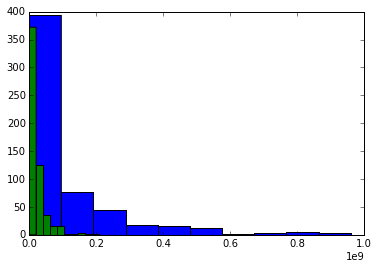

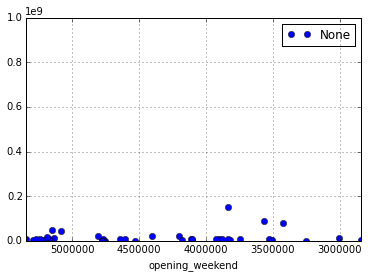

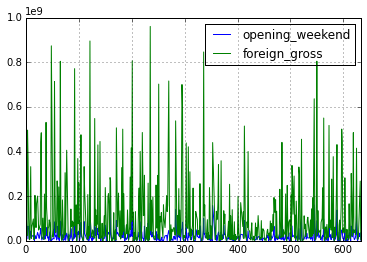

In [80]:
plt.hist(complete_df["foreign_gross"])
plt.hist(complete_df["opening_weekend"])


complete_df.plot(x="opening_weekend", y="foreign_gross", style='o')

complete_df[["opening_weekend", "foreign_gross"]].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e7b5f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ee5b590>]], dtype=object)

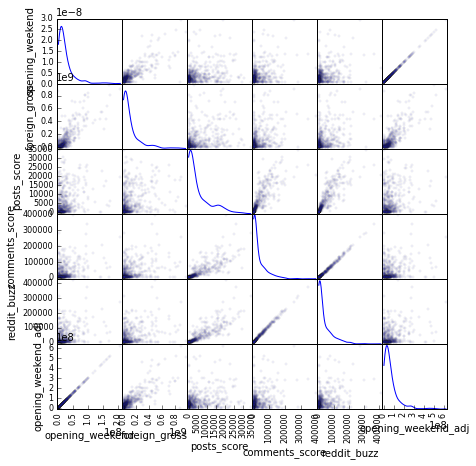

In [81]:
scatter_matrix(complete_df, alpha=0.05, figsize=(7,7), diagonal='kde')

In [82]:
model = smf.ols(formula="foreign_gross ~ opening_weekend", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     941.9
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          5.38e-123
Time:                        18:34:03   Log-Likelihood:                -11372.
No. Observations:                 574   AIC:                         2.275e+04
Df Residuals:                     572   BIC:                         2.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        7.223e+06   5.28e+06      1.369      0.172     -3.14e+06  1.76e+07
opening_weekend     4.5823      0.149     30.691      0.000         4.289     4.876
==============================================================================
Omnibus:                      358.698   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5858.441
Skew:                           2.453   Prob(JB):                         0.00
Kurtosis:                      17.862   Cond. No.                     4.58e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     494.7
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          2.26e-125
Time:                        18:38:54   Log-Likelihood:                -11363.
No. Observations:                 574   AIC:                         2.273e+04
Df Residuals:                     571   BIC:                         2.275e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -2.493e+05   5.48e+06     -0.045      0.964      -1.1e+07  1.05e+07
opening_weekend     4.3734      0.155     28.240      0.000         4.069     4.678
reddit_buzz       329.2770     76.474      4.306      0.000       179.072   479.482
==============================================================================
Omnibus:                      354.021   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5576.383
Skew:                           2.422   Prob(JB):                         0.00
Kurtosis:                      17.481   Cond. No.                     4.83e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz + (opening_weekend*reddit_buzz)", data=complete_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          foreign_gross   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     336.1
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          1.33e-125
Time:                        18:38:58   Log-Likelihood:                -11360.
No. Observations:                 574   AIC:                         2.273e+04
Df Residuals:                     570   BIC:                         2.274e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                   -9.102e+06   6.33e+06     -1.438      0.151     -2.15e+07  3.33e+06
opening_weekend                 4.7522      0.207     23.005      0.000         4.346     5.158
reddit_buzz                   502.8714     98.813      5.089      0.000       308.789   696.953
opening_weekend:reddit_buzz -4.671e-06    1.7e-06     -2.751      0.006     -8.01e-06 -1.34e-06
==============================================================================
Omnibus:                      342.167   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5110.409
Skew:                           2.328   Prob(JB):                         0.00
Kurtosis:                      16.856   Cond. No.                     6.95e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""